# **Proyecto 2: Análisis Exploratorio**
- Brandon Sicay 21757
- Daniel Morales 21785
- Diana Fernández 21747
- Jennifer Toxcón 21276

El diagnóstico rápido y preciso de fracturas en la columna cervical es crucial para evitar el deterioro neurológico y la parálisis en los pacientes, especialmente después de un trauma. Aunque la tomografía computarizada ha reemplazado a los rayos X en la detección de fracturas, la presencia de enfermedades degenerativas y osteoporosis en pacientes de edad avanzada dificulta la identificación precisa de las fracturas. La creciente demanda de análisis rápidos y precisos en la radiología requiere soluciones con IA para mejorar la detección y localización de fracturas en la columna cervical.

La tarea consiste en determinar, a partir de imágenes de TC, si hay fracturas en alguna de las siete vértebras que componen la columna cervical (C1-C7). Se ignoran las fracturas en la base del cráneo, la columna torácica, las costillas y las clavículas.

El modelo debe determinar si hay fracturas y en qué vértebras se producen. Por paciente se esperan 8 resultados: Una para cada una de las siete vértebras cervicales y una «any» que indica si el paciente tiene o no algún tipo de fractura.

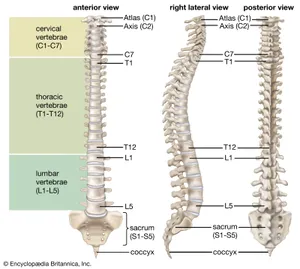

Además de identificar fracturas en las vértebras cervicales, el rendimiento del modelo se evalúa usando una métrica de pérdida logarítmica ponderada (log loss). Esta métrica mide qué tan bien las predicciones probabilísticas del modelo se ajustan a los resultados reales, penalizando más severamente los errores de predicción.

La fórmula del log loss es la siguiente:

$$
L_{ij} = - w_j \left( y_{ij} \log(p_{ij}) + (1 - y_{ij}) \log(1 - p_{ij}) \right)
$$



Donde:

- 𝑦𝑖𝑗 es la etiqueta verdadera para la predicción 𝑗 (1 si hay fractura, 0 si no).
- 𝑝𝑖𝑗 es la probabilidad predicha por el modelo.
- 𝑤𝑗 es el peso asignado a cada tipo de predicción.




#### Pesos

La competencia otorga diferentes pesos a los tipos de predicciones para reflejar su relevancia:

- Fractura negativa en una vértebra: Peso de 1 (menos severo si no hay fractura).
- Fractura positiva en una vértebra: Peso de 2 (más importante si hay fractura en una vértebra).
- Sin fractura en el paciente (global): Peso de 7.
- Fractura positiva en el paciente (global): Peso de 14 (más crítico identificar correctamente si el paciente tiene alguna fractura en general).


### Ejemplo:
Si el modelo falla en predecir correctamente que un paciente tiene una fractura global, el error se multiplica por 14, destacando la importancia de predecir correctamente la fractura global en comparación con la predicción de una vértebra individual.

Esta métrica no solo evalúa si el modelo predice correctamente, sino también la confianza que el modelo tiene en sus predicciones. Los errores en fracturas globales del paciente se penalizan mucho más que en fracturas específicas, resaltando la necesidad de que el modelo sea especialmente preciso en identificar si el paciente tiene fracturas o no.

### Problema científico
¿Cómo puede la IA mejorar la precisión y velocidad en la detección y localización de fracturas en la columna cervical a través de imágenes de tomografía computarizada, igualando o superando el rendimiento de los radiólogos expertos?

### Objetivo General
Desarrollar un modelo capaz de detectar y localizar con precisión fracturas en las vértebras cervicales (C1-C7) utilizando imágenes de tomografía computarizada (CT), con el objetivo de mejorar la velocidad y precisión en el diagnóstico médico.

### Objetivos
- Desarrollar un modelo de aprendizaje automático que detecte y localice fracturas en las siete vértebras cervicales (C1-C7) a partir de imágenes de CT.
- Crear un sistema que pueda identificar la existencia de cualquier fractura vertebral en un paciente con alta precisión.
- Reducir el tiempo de diagnóstico y aumentar la precisión en la identificación de fracturas cervicales en pacientes con imágenes complejas, como aquellos con degeneración o enfermedades óseas.
- Comparar los resultados del modelo con la evaluación de radiólogos para validar su efectividad.

## Descripción del conjunto de datos

El conjunto de datos está compuesto por aproximadamente 3,000 estudios de tomografía computarizada (CT) que cubren las vértebras cervicales (C1-C7) y se obtuvo de 12 sitios diferentes alrededor del mundo. 

Los datos incluyen imágenes en formato DICOM de alta resolución y etiquetas proporcionadas por radiólogos que indican la presencia y localización de fracturas. También se proporcionan segmentaciones de las vértebras mediante un modelo UNET 3D, revisadas por radiólogos para su precisión. Además, se incluye un conjunto de datos de cajas delimitadoras para un subconjunto de las imágenes, con el objetivo de facilitar el entrenamiento del modelo para identificar fracturas específicas.


### Variables

- StudyInstanceUID: ID único del estudio de imagen para cada paciente.

- patient_overall: Indica si existe alguna fractura en cualquier vértebra cervical para el paciente.

- C1, C2, C3, C4, C5, C6, C7: Variables binarias que indican la presencia o ausencia de fracturas en las vértebras específicas.

- StudyInstanceUID: ID único del estudio de imagen.

- x y y: Coordenadas mínimas de la caja delimitadora que encierra la fractura.

- width: Coordenadas máximas de la caja delimitadora.

- C1, C2, C3, C4, C5, C6, C7: Identificadores de las vértebras en las que se encuentran las fracturas C1-C7.

- row_id: ID único correspondiente a la predicción.

- fractured: La probabilidad de que haya una fractura en la vértebra o en el paciente (patient_overall).


In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Leer los archivos CSV
train_df = pd.read_csv('./data_cervical/train.csv')
test_df= pd.read_csv('./data_cervical/test.csv')
train_bounding_boxes= pd.read_csv('./data_cervical/train_bounding_boxes.csv')
sample_submission = pd.read_csv('./data_cervical/sample_submission.csv')

In [6]:
print("Train data:")
print(train_df.head())

Train data:
            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0


In [7]:
train_df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


In [8]:
# Ver las primeras filas de cada DataFrame
print("Train data:")
print(test_df.head())

Train data:
                         row_id           StudyInstanceUID prediction_type
0  1.2.826.0.1.3680043.10197_C1  1.2.826.0.1.3680043.10197              C1
1  1.2.826.0.1.3680043.10454_C1  1.2.826.0.1.3680043.10454              C1
2  1.2.826.0.1.3680043.10690_C1  1.2.826.0.1.3680043.10690              C1


- StudyInstanceUID: ID único del estudio de imagen para cada paciente.

- patient_overall: Indica si existe alguna fractura en cualquier vértebra cervical para el paciente.

- C1, C2, C3, C4, C5, C6, C7: Variables binarias que indican la presencia o ausencia de fracturas en las vértebras específicas.

In [9]:
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


- row_id: El ID de la fila. Coincidirá con la misma columna del archivo de envío de muestras.
- StudyInstanceUID: ID del estudio que es único para cada exploración de paciente.
- prediction_type: Cuál de las ocho columnas objetivo necesita una predicción en esta fila.

In [11]:
train_bounding_boxes

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


- StudyInstanceUID: ID del estudio que es único para cada paciente escaneado.
- x: coordenada x de la esquina inferior izquierda del cuadro delimitador.
- y: coordenada y de la esquina inferior izquierda del cuadro delimitador.
- width: anchura del cuadro delimitador
- height: altura del cuadro delimitador
- slice_number: número de corte del escaneado

In [13]:
# Ver las primeras filas de cada DataFrame
print("Sample submission:")
print(sample_submission.head())

Sample submission:
                         row_id  fractured
0  1.2.826.0.1.3680043.10197_C1        0.5
1  1.2.826.0.1.3680043.10454_C1        0.5
2  1.2.826.0.1.3680043.10690_C1        0.5


In [14]:
sample_submission

,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


- row_id: Único para cada escaneo de paciente incluyendo las vértebras afectadas.
- fractured: Columna objetivo con predicción.

## Análisis exploratorio

Análisis 

El desglose global de los datos es 1058 (52,4% sin fractura) y 961 (47,6% con fractura). De los pacientes con fracturas, hay varios que tienen más de una.

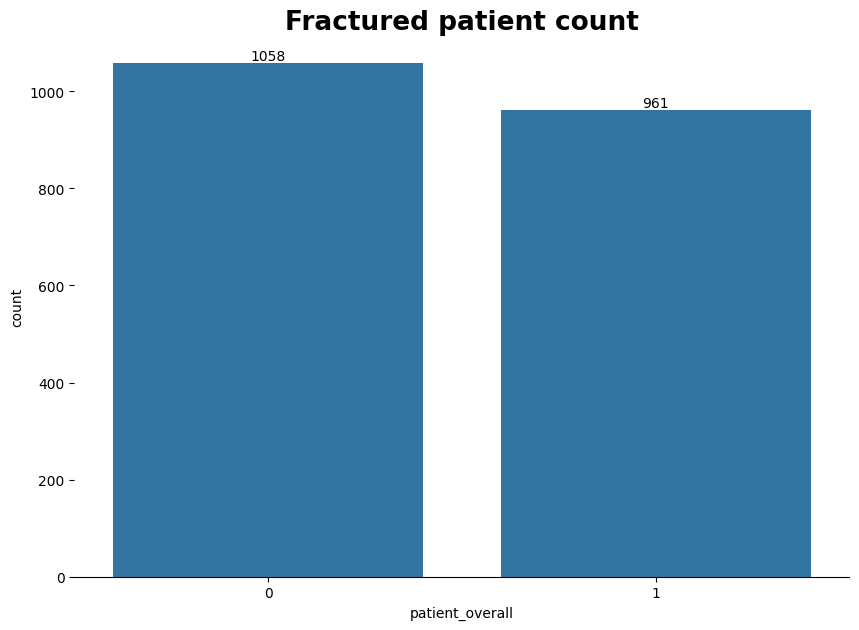

In [16]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(data=train_df, x="patient_overall")
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Fractured patient count", weight="bold", size=19)
sns.despine(right=True, top=True, left=True);

(0.0, 2800.0)

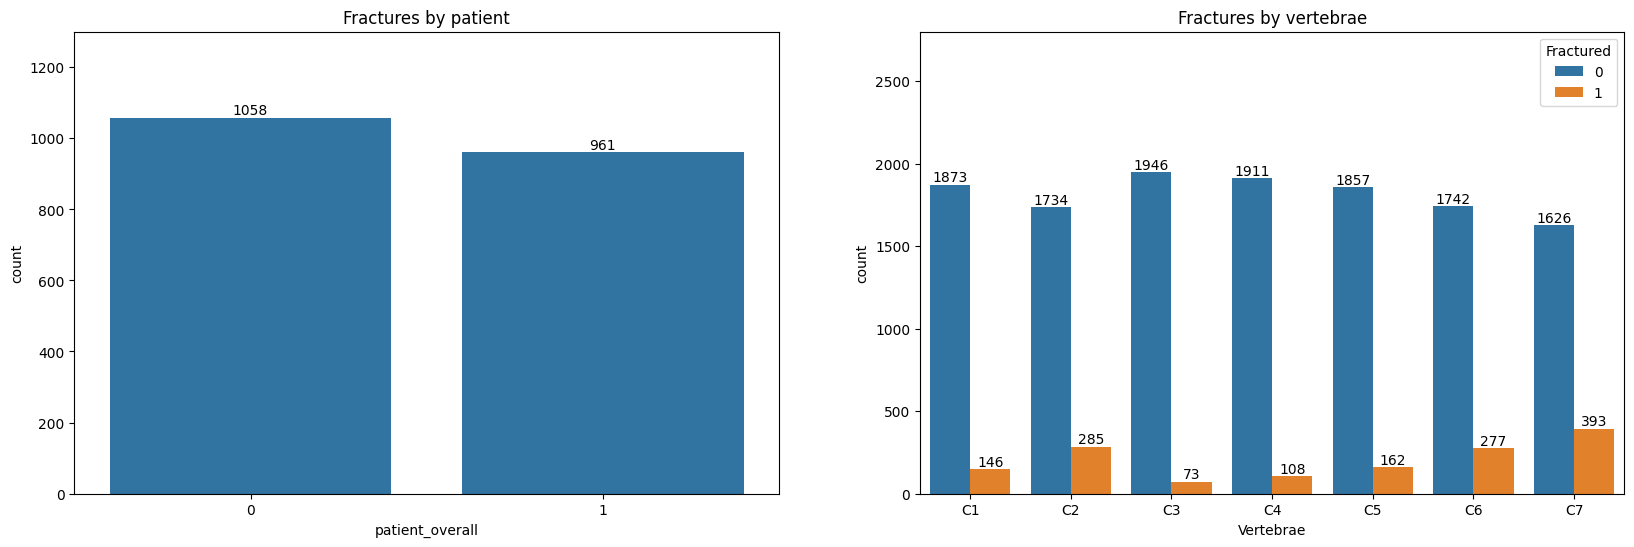

In [23]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])

# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])


La mayoría de las fracturas aparecen en las vértebras superiores e inferiores, siendo C7 (27,22%) y C2 (19,74%) las que presentan la mayor proporción. C3 (5,06%) y C4 (7,48%) tienen la porción más baja.

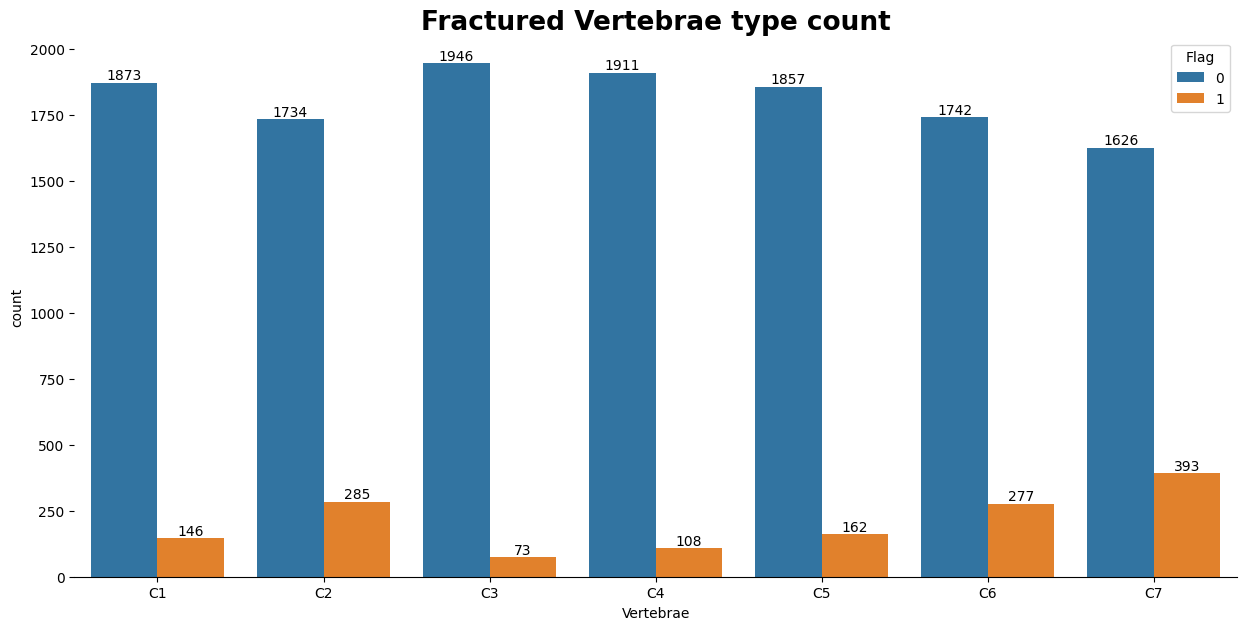

In [17]:
data_count = pd.melt(train_df, 
             id_vars=['StudyInstanceUID', 'patient_overall'],
             var_name="Vertebrae",
             value_name="Flag")

plt.figure(figsize=(15, 7))
ax = sns.countplot(data=data_count, x="Vertebrae", hue="Flag")
for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Fractured Vertebrae type count", weight="bold", size=19)
sns.despine(right=True, top=True, left=True);

In [18]:
percentage_table = data_count[["Vertebrae","Flag"]].groupby("Vertebrae").sum()
percentage_table["percentage"] = np.round((percentage_table["Flag"] / percentage_table["Flag"].sum())*100,2)
percentage_table

,Flag,percentage
Vertebrae,,
C1,146,10.11
C2,285,19.74
C3,73,5.06
C4,108,7.48
C5,162,11.22
C6,277,19.18
C7,393,27.22


Si un paciente tiene varias fracturas, es más probable que estén en una vértebra limítrofe. Por ejemplo, es más probable que una fractura en C1 esté junto a una fractura en C2 que en C5.

Text(0.5, 1.0, 'Correlations')

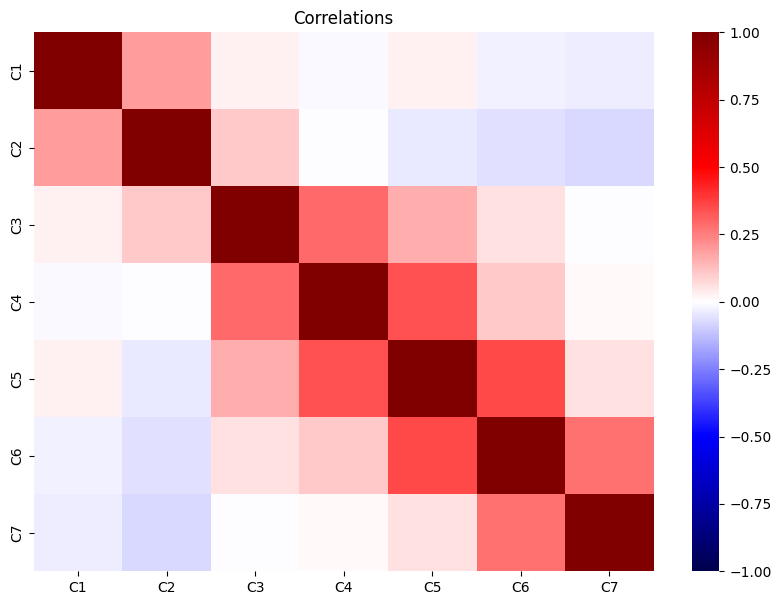

In [19]:
plt.figure(figsize=(10,7))
corr = train_df[['C1','C2','C3','C4','C5','C6','C7']].corr()
sns.heatmap(corr, cmap="seismic", vmin=-1, vmax=1)
plt.title('Correlations')

### ID de los pacientes
Cada paciente tiene un ID único que se utiliza para identificarlo. Este es también el ID que debe utilizarse para la salida (envío) en combinación con las vértebras y la evaluación global 

In [20]:
for x in range(20):
    print(train_df["StudyInstanceUID"][x])

1.2.826.0.1.3680043.6200
1.2.826.0.1.3680043.27262
1.2.826.0.1.3680043.21561
1.2.826.0.1.3680043.12351
1.2.826.0.1.3680043.1363
1.2.826.0.1.3680043.4859
1.2.826.0.1.3680043.18659
1.2.826.0.1.3680043.17364
1.2.826.0.1.3680043.849
1.2.826.0.1.3680043.24045
1.2.826.0.1.3680043.4744
1.2.826.0.1.3680043.15773
1.2.826.0.1.3680043.24946
1.2.826.0.1.3680043.9290
1.2.826.0.1.3680043.5482
1.2.826.0.1.3680043.11090
1.2.826.0.1.3680043.13810
1.2.826.0.1.3680043.28252
1.2.826.0.1.3680043.26052
1.2.826.0.1.3680043.4131


Al mirar los ID de los estudios, surge la suposición de que sólo los números después del último período son únicos (samuelcortinhas, 2022).

In [24]:
for i in range(7):
    print(train_df['StudyInstanceUID'].map(lambda x : x.split('.')[i]).unique())

['1']
['2']
['826']
['0']
['1']
['3680043']
['6200' '27262' '21561' ... '14341' '12053' '18786']


Referencias

samuelcortinhas. (2022, August 18). 🦴 RSNA Fracture Detection - in-depth EDA. Kaggle.com; Kaggle. https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda
